# AirBnB & Zillow Data Challenge - NYC Real Estate Investment Analysis

## Business Problem Statement 

A real estate company is seeking opportunities to invest the most promising regions in New York City for short-term rental business. The two-bedroom propeties has already been proved as the most profitable type of properties; and we need to find the rergions that can generate the most profit among all of them.  

The revenue data comes from the lately scraped data on Airbnb, which is the medium through which the investor plans to lease out their investment property. The cost data comes from Zillow, which is an estimate of value for two-bedroom properties only. 

There are certain **assumptions** in this tasks:   
1. the real estate investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).  
2. the time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).  
3. all properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)

## Basic Apporach

To address this problem, we need to quantify the "profit" for each region. In order to decompose this problem for further analysis, we can create a formula to calculate the "profit":  

**CAP_RATE(CAPITALIZATION RATE) = Revenue / Cost = Rental Price * length(Time) * Occupancy / Invest Cost**

In real estate investment industry, the commonly used metric to reflect the "porfit" is the so called Capitalization Rate. Only the "profit" itself is not strong enough to indicate the investmnt value of a property. For example, high price and low price properties might generate the same "profit", however the return of investment is clearly not the same. Therefore, here we use "CAP RATE" to analysis the investment value for different region in New York City.

However, by comparing the Capitalization Rate for a certain time point to decide which region is the most valuable for investment purpose is somehow limited. If we are going to use the Capitalization Rate in the end of the following year, there might be that the property with lower Capitalization Rate has a higher development potential. The high development potential might not be noticeable in very short term - like one year or so, but would generate a huge impact on the region in the long term - maybe 5 or 10 years. Considering this aspect, we also need to include the "Development Potential Factor(DPF)" in our original formula. The finalized formula should be: 

**Region Value Metric  
= CAP_RATE * Development Potential Factor(DPF)  
= (Revenue / Cost) * DPF                       
= (Rental Price * length(Time) * Occupancy / Invest Cost) * DPF**

So, we are going to take original Capitalization Rate, Development Potential Factor as well as Derived Region Value Metric all into consideration. The result from only one metric is not compelling enough, hence we will find the union set of those result as most promising region to invest.

## Data Quality Check

### Data Import

In [396]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.patches as patches
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 20)
%matplotlib inline 

In [397]:
listing = pd.read_csv("/Users/peiningfan/Documents/job/CapitalOne/raw_data/listings.csv")
purchasing = pd.read_csv("/Users/peiningfan/Documents/job/CapitalOne/raw_data/Zip_Zhvi_2bedroom.csv")

After importing Zillow and Airbnb dataset, we need to do some quality check and deal with imperfect data in it. 

**For Zillow Dataset:**  
First we want to observe the first several data records in Zillow dataset and learn about what are the different data types for each column. Then, we need to inspect the content in both 'State' and 'City' column. This is to make sure when we are using 'City' column euqal to "New York", it will not leave out some bad-formatting New York City data. After that, we also need to check whether the regionID is unique. According to the dataset explanation, each row in Zillow dataset store the historical real estate pricing data for each region.

In [398]:
purchasing.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


In [399]:
purchasing.dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
               ...   
2016-09         int64
2016-10         int64
2016-11         int64
2016-12       float64
2017-01         int64
2017-02         int64
2017-03         int64
2017-04         int64
2017-05         int64
2017-06         int64
Length: 262, dtype: object

In [400]:
# A quick inspect of State data in zillow dataset
purchasing['State'].unique()

array(['NY', 'IL', 'TX', 'CA', 'FL', 'TN', 'NC', 'GA', 'DC', 'MD', 'MO',
       'VA', 'NJ', 'OK', 'OH', 'AZ', 'KS', 'NM', 'WA', 'CT', 'NV', 'MA',
       'PA', 'MI', 'CO', 'KY', 'OR', 'SC', 'IN', 'ND', 'AR', 'AL', 'MN',
       'DE', 'MS', 'ID', 'MT', 'WI', 'HI', 'UT', 'LA', 'RI', 'IA', 'NE',
       'WY', 'AK', 'NH', 'WV'], dtype=object)

In [401]:
# A quick inspect of City data in zillow dataset
purchasing['City'].unique()

array(['New York', 'Chicago', 'El Paso', ..., "Hart'S Location",
       'Waterville Valley', 'Shelburne Falls'], dtype=object)

The data in the 'State' column seems to be neat, so we can locate all the data records which the State is 'NY' to further filter out the City 'New York' in them. This step aims to prevent messy data in 'City' column. This way we can keep all the 'New York' city data step by step without any mistake.

In [402]:
# To filter out the data in New York State
check1 = purchasing[purchasing['State'] == 'NY'] 

In [403]:
# A quick inspect of New York State data
check1['City'].unique()

array(['New York', 'Ithaca', 'Yonkers', 'Town of Webster',
       'Town of Lockport', 'Huntington', 'Town of Newburgh', 'Middletown',
       'North Tonawanda', 'Clifton Park', 'Union', 'Town of Islip',
       'Saratoga Springs', 'Rochester', 'Perinton', 'Town of Watertown',
       'Auburn', 'Patchogue', 'Long Beach', 'Town of Poughkeepsie',
       'Ramapo', 'Chili', 'Kingston', 'Town of Greece',
       'Town of Plattsburgh', 'Scarsdale', 'Town of Monroe', 'Wappinger',
       'Town of Oswego', 'Lysander', 'Lindenhurst', 'Freeport', 'Malta',
       'Niagara Falls', 'Albany', 'Ronkonkoma', 'Port Chester',
       'Town of Pittsford', 'Schenectady', 'Liverpool',
       'Town of Niskayuna', 'Town of Amsterdam', 'Smithtown',
       'Town of Colonie', 'East Hampton', 'Glenville', 'Binghamton',
       'Queensbury', 'Cortland', 'Ossining', 'Coram', 'Town of Rotterdam',
       'Riverhead', 'Elmont', 'Clarkstown', 'Irondequoit', 'Yorktown',
       'Syracuse', 'Gloversville', 'New Windsor', 'Carmel

The New York State data is well-organized and well-stored, therefore we can filter out the 'New York' City data using purchasing['City'] == 'New York' condition.

In [404]:
# To filter out the data in NYC
check2 = purchasing[purchasing['City'] == 'New York'] 

In [405]:
# Check the uniqueness of NYC real estate price metadata
print('The purchasing dataset size: {0}'.format(check2.shape)) 
print('The number of unique RegionID: {0}'.format(check2['RegionID'].nunique()))
print('The number of unique RegionName: {0}'.format(check2['RegionName'].nunique()))
print('The number of unique City: {0}'.format(check2['City'].nunique()))
print('The unique City: {0}'.format(check2['City'].unique()))

The purchasing dataset size: (25, 262)
The number of unique RegionID: 25
The number of unique RegionName: 25
The number of unique City: 1
The unique City: ['New York']


**For Airbnb dataset:**  
We apply the same steps in Airbnb dataset just like Zillow dataset.

In [406]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.38
2,3647,https://www.airbnb.com/rooms/3647,20190708031610,2019-07-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3,3831,https://www.airbnb.com/rooms/3831,20190708031610,2019-07-09,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
4,5022,https://www.airbnb.com/rooms/5022,20190708031610,2019-07-08,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10


In [407]:
listing.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
                                                 ...   
instant_bookable                                 object
is_business_travel_ready                         object
cancellation_policy                              object
require_guest_profile_picture                    object
require_guest_phone_verification                 object
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes     

In [408]:
# Check the data for 'state' column
listing['state'].unique()

array(['NY', nan, 'Ny', 'ny', 'MP', 'CA', 'NJ', 'New York '], dtype=object)

The data in 'state' column is messy, and we can tell that 'NY', 'Ny', 'ny' and 'New York ' should all be New York State data. However, we are not sure about the 'nan' value in 'state' column. To be as accurate as we can, we can keep the 'nan' data records for now and manually correct errors in the following steps. At the meanwhile, we can filter out 2-bedroom data in this step to narrow down the dataset.

In [409]:
check3 = listing[(listing['state'] == 'NY') | (listing['state'] == 'Ny') | (listing['state'] == 'ny') | (listing['state'] == 'New York ') | (listing['state'].isnull == True)]
check3 = check3[(check3['bedrooms'] == 2.0)]

In [410]:
# Check the data for 'city' column
check3['city'].unique()

array(['New York', 'Brooklyn', 'Queens', 'Long Island City', 'Riverdale ',
       'Bronx', 'Staten Island', 'Brooklyn ', 'Astoria', 'Jamaica',
       'ASTORIA', 'long island city', 'NY', 'Kew Garden Hills\nnew York',
       'LONG ISLAND CITY', 'Rockaway beach', 'Fort Greene, Brooklyn',
       'Park Slope, Brooklyn', 'bronx', 'Saint Albans(Queens)',
       'EAST ELMHURST', 'jackson heights', 'New York City', 'Woodside',
       nan, 'Astoria ', 'Brooklyn, New York', 'Bushwick/Ridgewood',
       'Forest Hills', 'RIVERDALE', 'Bushwick', 'astoria',
       'Chelsea, New York', 'Long Island city', 'Fresh Meadows ',
       'MIDDLE VILLAGE', 'new york', 'East Elmhurst', 'New York ',
       'Queens ', 'Jackson Heights', 'Brookyn ', 'Ridgewood', 'Flushing ',
       'Rockaway Beach', 'Forest Hills ', 'Rosedale ',
       'Williamsburg,Brooklyn', 'Flushing', 'Jackson Heights ',
       'Greenpoint, Brooklyn', 'Brooklyn, NY 11221 ', 'Ridgewood ',
       'flushing', 'Howard Beach', 'Glendale ', 'Arvern

Since the data stored in 'state' and 'city' is really messy, we can just leave the Airbnb listing dataset as it is. The best solution to address the problem of filtering out the correct data records of New York City is to merge the Airbnb data with zillow data to keep the overlap zipcode. This way, we can make sure all the data to be New York City's.

### Missing Value Treatment

**For Zillow dataset:**  
Since some of the columns are not of interests to our analysis, we choose to first drop those irrelevant columns before we get down to the missing value treatment part.

In [411]:
# Keep only the zipcode and monthly price column for further uses
check2 = check2.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])

In [412]:
check2.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
2,10023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
13,10128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
14,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
20,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


In [413]:
# Check the percentage of missing value in each column
check2.isna().sum()/len(check2)

RegionName    0.00
1996-04       0.68
1996-05       0.68
1996-06       0.68
1996-07       0.68
1996-08       0.68
1996-09       0.68
1996-10       0.68
1996-11       0.68
1996-12       0.68
              ... 
2016-09       0.00
2016-10       0.00
2016-11       0.00
2016-12       0.00
2017-01       0.00
2017-02       0.00
2017-03       0.00
2017-04       0.00
2017-05       0.00
2017-06       0.00
Length: 256, dtype: float64

The result above shows that some old years do not have much price data stored in this dataset. The percentage of missing price data drops to 0.00 ever since 2007-06. So we can choose the recent 10 year data in Zillow dataset for further analysis.

In [414]:
# Drop the columns with too much NA value and keep only the most recent 10 year data
check2 = check2.drop(check2.loc[:, '1996-04':'2009-06'].columns, axis = 1) 

In [415]:
# Check the data after droping some columns
check2.reset_index(drop = True, inplace = True)
check2.head()

,RegionName,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10025,850200.0,842800.0,834000.0,828800.0,821400.0,813900.0,813300.0,821500.0,831700.0,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,10023,1362600.0,1351700.0,1344300.0,1331800.0,1334800.0,1314200.0,1271900.0,1252300.0,1262300.0,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
2,10128,981400.0,971200.0,961700.0,957500.0,959300.0,969400.0,985400.0,983700.0,983400.0,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
3,10011,1489200.0,1467000.0,1449400.0,1432100.0,1422700.0,1402200.0,1378600.0,1372300.0,1393100.0,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
4,10003,1375100.0,1361300.0,1333400.0,1299700.0,1296500.0,1273900.0,1227800.0,1202600.0,1207100.0,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


**For Airbnb dataset:**

Similarly, we apply the same methonology to Airbnb dataset. First choose relevant columns and then do missing value treatment.

Based on the observation and knowledge about Airbnb, whether the room_type is entire house or private room is important. Since Airbnb use same id (means same listing_url) for all the private rooms in one property, we need to multiply the private-type data's renting price with two in order to get the correct price for the entire property. To calculate more rational occupancy for different airbnb listings, we can use the availability in the next amount of time to make rough estimate. We also want to keep the review data for data visualization uses.

In [416]:
# A qucik inspect of zillow price data
temp = check3[['zipcode','price','weekly_price','monthly_price','room_type','availability_30','availability_60','availability_90','availability_365','number_of_reviews','review_scores_rating','reviews_per_month']]
temp.head()

,zipcode,price,weekly_price,monthly_price,room_type,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month
19,10029,$190.00,NaN,NaN,Entire home/apt,4,14,14,249,0,NaN,NaN
48,11221,$115.00,$850.00,NaN,Entire home/apt,0,0,0,0,11,94.0,0.10
52,11206,$228.00,NaN,NaN,Entire home/apt,14,20,50,140,82,94.0,0.70
61,10001,$375.00,"$2,750.00","$7,500.00",Entire home/apt,30,60,90,180,5,100.0,0.12
62,10162,$250.00,"$2,000.00","$6,000.00",Entire home/apt,0,12,28,231,66,93.0,0.57


In [417]:
# Check the data after dropping some columns
temp.reset_index(drop=True, inplace=True)
temp.head()

,zipcode,price,weekly_price,monthly_price,room_type,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month
0,10029,$190.00,NaN,NaN,Entire home/apt,4,14,14,249,0,NaN,NaN
1,11221,$115.00,$850.00,NaN,Entire home/apt,0,0,0,0,11,94.0,0.10
2,11206,$228.00,NaN,NaN,Entire home/apt,14,20,50,140,82,94.0,0.70
3,10001,$375.00,"$2,750.00","$7,500.00",Entire home/apt,30,60,90,180,5,100.0,0.12
4,10162,$250.00,"$2,000.00","$6,000.00",Entire home/apt,0,12,28,231,66,93.0,0.57


In [418]:
# Check NA value percentage for each column
temp.isna().sum()/len(temp)

zipcode                 0.007697
price                   0.000000
weekly_price            0.878387
monthly_price           0.892857
room_type               0.000000
availability_30         0.000000
availability_60         0.000000
availability_90         0.000000
availability_365        0.000000
number_of_reviews       0.000000
review_scores_rating    0.212746
reviews_per_month       0.196890
dtype: float64

The result above shows that most of the Airbnb listing don't have weekly and monthly price. Therefore we choose to use only the daily price("price" column in the dataset) to do our estimation for revenue.

In [419]:
temp = temp.drop(columns = ['weekly_price','monthly_price'])

In [420]:
temp['zipcode'] = temp['zipcode'].fillna(0)

In [421]:
temp.isna().sum()

zipcode                    0
price                      0
room_type                  0
availability_30            0
availability_60            0
availability_90            0
availability_365           0
number_of_reviews          0
review_scores_rating    1382
reviews_per_month       1279
dtype: int64

In [422]:
temp.head()

,zipcode,price,room_type,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month
0,10029,$190.00,Entire home/apt,4,14,14,249,0,NaN,NaN
1,11221,$115.00,Entire home/apt,0,0,0,0,11,94.0,0.10
2,11206,$228.00,Entire home/apt,14,20,50,140,82,94.0,0.70
3,10001,$375.00,Entire home/apt,30,60,90,180,5,100.0,0.12
4,10162,$250.00,Entire home/apt,0,12,28,231,66,93.0,0.57


After the missing value treantment, we still have certain rows of data that lack of 'review_scores_rating' and     'reviews_per_month' information. We are not going to replace those NA value with zero for now. Since the review relevant data is only used for exploratory data visualization, missing value would not bother the final result.

### Data Transformation

**For Zillow dataset:**  
To better present and store the Zillow dataset, we transpose the dataset.

In [423]:
# Store transposed NYC real estate price metadata(recent 10 years: start from 2009/07) into variable 'price' 
monthly_price = check2.set_index('RegionName')
del monthly_price.index.name
price = monthly_price.transpose()
price.tail()

,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,...,10312,10022,11217,10013,11231,10304,10305,10309,10308,10303
2017-02,1317300.0,1929800.0,1582900.0,2319600.0,1916500.0,1398100.0,466400.0,338600.0,1040800.0,1801100.0,...,339300.0,1774500.0,1225000.0,3183300.0,1182900.0,303800.0,394500.0,364900.0,378000.0,304700.0
2017-03,1333700.0,1955000.0,1598900.0,2342100.0,1965700.0,1399900.0,470900.0,344100.0,1035800.0,1847900.0,...,345000.0,1812700.0,1219600.0,3160200.0,1202200.0,308300.0,403800.0,371100.0,387800.0,309500.0
2017-04,1352100.0,2022400.0,1646100.0,2365900.0,2045300.0,1400500.0,475700.0,347800.0,1050000.0,1922800.0,...,348400.0,1914600.0,1238100.0,3193500.0,1213200.0,313800.0,412000.0,377200.0,396400.0,315400.0
2017-05,1390000.0,2095000.0,1720500.0,2419700.0,2109100.0,1407300.0,477100.0,352300.0,1066200.0,2015700.0,...,351700.0,1997800.0,1276400.0,3262200.0,1211700.0,321300.0,418900.0,383700.0,402900.0,322100.0
2017-06,1431000.0,2142300.0,1787100.0,2480400.0,2147000.0,1420700.0,476900.0,357300.0,1070800.0,2083900.0,...,355000.0,2031600.0,1302300.0,3316500.0,1202900.0,328300.0,425100.0,390500.0,409500.0,327700.0


We also create a new dataframe to store the Zillow rreral estate pricing data within quarter level using mean value aggregation method. The reason for this is to decrease the number of data records for each region, which can help us to create more scalable pricing trend visualization.

In [424]:
# Aggregate the data NYC real estate price metadata from monthly into Quarter level
quarter_price = price.groupby(np.arange(len(price))//3).mean()
quarter_price.head()

,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,...,10312,10022,11217,10013,11231,10304,10305,10309,10308,10303
0,842333.333333,1.352867e+06,9.714333e+05,1.468533e+06,1.356600e+06,693266.666667,367266.666667,283433.333333,506933.333333,1.180533e+06,...,297733.333333,1.306800e+06,604166.666667,2.239367e+06,570133.333333,269666.666667,325733.333333,310966.666667,316666.666667,259466.666667
1,821366.666667,1.326933e+06,9.620667e+05,1.419000e+06,1.290033e+06,721400.000000,366000.000000,281666.666667,503833.333333,1.159733e+06,...,297800.000000,1.280833e+06,601066.666667,2.209067e+06,585366.666667,265766.666667,327400.000000,315300.000000,318366.666667,258466.666667
2,822166.666667,1.262167e+06,9.841667e+05,1.381333e+06,1.212500e+06,746866.666667,385633.333333,289900.000000,538333.333333,1.116467e+06,...,296500.000000,1.335367e+06,617000.000000,2.278800e+06,590133.333333,265666.666667,329733.333333,319133.333333,324433.333333,267433.333333
3,852833.333333,1.307833e+06,1.013700e+06,1.456300e+06,1.252733e+06,759100.000000,393200.000000,287400.000000,538166.666667,1.171367e+06,...,295200.000000,1.354733e+06,612866.666667,2.277500e+06,592000.000000,261333.333333,324433.333333,313300.000000,324933.333333,260866.666667
4,866233.333333,1.364100e+06,1.017700e+06,1.472267e+06,1.294700e+06,769700.000000,391333.333333,287200.000000,551200.000000,1.213733e+06,...,295133.333333,1.399100e+06,606800.000000,2.286600e+06,600733.333333,260000.000000,320166.666667,313700.000000,325000.000000,257166.666667


In [425]:
# reset index as quarter
quarter_price['quarter'] = ['2009Q3','2009Q4','2010Q1','2010Q2',
                            '2010Q3','2010Q4','2011Q1','2011Q2',
                            '2011Q3','2011Q4','2012Q1','2012Q2',
                            '2012Q3','2012Q4','2013Q1','2013Q2',
                            '2013Q3','2013Q4','2014Q1','2014Q2',
                            '2014Q3','2014Q4','2015Q1','2015Q2',
                            '2015Q3','2015Q4','2016Q1','2016Q2',
                            '2016Q3','2016Q4','2017Q1','2017Q2'] 

quarter_price.set_index(['quarter'], inplace = True, drop = True)
quarter_price.head()

,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,...,10312,10022,11217,10013,11231,10304,10305,10309,10308,10303
quarter,,,,,,,,,,,,,,,,,,,,,
2009Q3,842333.333333,1.352867e+06,9.714333e+05,1.468533e+06,1.356600e+06,693266.666667,367266.666667,283433.333333,506933.333333,1.180533e+06,...,297733.333333,1.306800e+06,604166.666667,2.239367e+06,570133.333333,269666.666667,325733.333333,310966.666667,316666.666667,259466.666667
2009Q4,821366.666667,1.326933e+06,9.620667e+05,1.419000e+06,1.290033e+06,721400.000000,366000.000000,281666.666667,503833.333333,1.159733e+06,...,297800.000000,1.280833e+06,601066.666667,2.209067e+06,585366.666667,265766.666667,327400.000000,315300.000000,318366.666667,258466.666667
2010Q1,822166.666667,1.262167e+06,9.841667e+05,1.381333e+06,1.212500e+06,746866.666667,385633.333333,289900.000000,538333.333333,1.116467e+06,...,296500.000000,1.335367e+06,617000.000000,2.278800e+06,590133.333333,265666.666667,329733.333333,319133.333333,324433.333333,267433.333333
2010Q2,852833.333333,1.307833e+06,1.013700e+06,1.456300e+06,1.252733e+06,759100.000000,393200.000000,287400.000000,538166.666667,1.171367e+06,...,295200.000000,1.354733e+06,612866.666667,2.277500e+06,592000.000000,261333.333333,324433.333333,313300.000000,324933.333333,260866.666667
2010Q3,866233.333333,1.364100e+06,1.017700e+06,1.472267e+06,1.294700e+06,769700.000000,391333.333333,287200.000000,551200.000000,1.213733e+06,...,295133.333333,1.399100e+06,606800.000000,2.286600e+06,600733.333333,260000.000000,320166.666667,313700.000000,325000.000000,257166.666667


**For Airbnb dataset:**  
The data in price relevant column is string with dollar sign and comma. In order to use those numeric data in the analysis part, we need to convert them into correct format.   
Here I write a function called 'remove_dollar_comma' for auto replacement in case of new dataset comes in.

In [426]:
# Replace missing value with 0 and remove dollar sign from price relevant columns    
def remove_dollar_comma(dataset,col):
    for i in list(range(dataset.shape[0])): # 6496 is the length of clean data
        if dataset[col][i] != 0:
            dataset[col][i] = dataset[col][i].replace('$','').replace(',','')
                
remove_dollar_comma(temp,'price')

To acquire the correct price for the entire property, we need to recalculate the price data based on the room type.

In [427]:
def room_num_convert(df):
    mutiplier = []
    for row in df['room_type']:
        if row == 'Entire home/apt':
            mutiplier.append(int(1))
        elif row == 'Private room':
            mutiplier.append(int(2))
    # Create a column from the list
    df['room_num'] = mutiplier
    
room_num_convert(temp)

del temp['room_type']

temp['zipcode'] = temp['zipcode'].astype(int)
temp['price'] = temp['price'].astype(float)

temp['price'] = temp['price'] * temp['room_num']

del temp['room_num']

To make availability data more scalable and easier to compare, we create new columns to store the percentage of availability.

In [428]:
def availability_ratio(df):
    df['availability_30_ratio'] = df['availability_30'] / 30
    df['availability_60_ratio'] = df['availability_60'] / 60
    df['availability_90_ratio'] = df['availability_90'] / 90
    df['availability_365_ratio'] = df['availability_365'] / 365
    
availability_ratio(temp)    

In [429]:
rent = temp
rent.head()

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
0,10029,190.0,4,14,14,249,0,NaN,NaN,0.133333,0.233333,0.155556,0.682192
1,11221,115.0,0,0,0,0,11,94.0,0.10,0.000000,0.000000,0.000000,0.000000
2,11206,228.0,14,20,50,140,82,94.0,0.70,0.466667,0.333333,0.555556,0.383562
3,10001,375.0,30,60,90,180,5,100.0,0.12,1.000000,1.000000,1.000000,0.493151
4,10162,250.0,0,12,28,231,66,93.0,0.57,0.000000,0.200000,0.311111,0.632877


With the intention of visualizing the avearge daily price and total number of properties in each region, here we aggregate the data based on their zipcode.

In [430]:
zillow_zipcode = quarter_price.columns.tolist()
daily = rent[rent['zipcode'].isin(zillow_zipcode)].reset_index(drop=True)
daily_renting_price = daily.groupby('zipcode')\
                            .agg({'price':'mean','number_of_reviews':'size','availability_30_ratio':'mean','availability_60_ratio':'mean', 'availability_90_ratio':'mean', 'availability_365_ratio':'mean'})\
                            .rename(columns={'price':'mean_price','number_of_reviews':'count', 'availability_30_ratio':'a30', 'availability_60_ratio':'a60', 'availability_90_ratio':'a90', 'availability_365_ratio':'a365'})\
                            .reset_index()

In [431]:
daily_renting_price

,zipcode,mean_price,count,a30,a60,a90,a365
0,10003,326.132353,136,0.187990,0.250858,0.265686,0.295911
1,10011,373.764151,106,0.174214,0.240723,0.264885,0.286172
2,10013,412.466667,105,0.327937,0.368095,0.365608,0.330124
3,10014,348.955556,90,0.221111,0.272407,0.281358,0.257108
4,10021,281.629630,27,0.164198,0.203704,0.218519,0.291020
5,10022,354.591549,71,0.290610,0.430516,0.489045,0.595022
6,10023,298.628205,78,0.171368,0.270299,0.284473,0.444995
7,10025,333.120968,124,0.110484,0.162500,0.178315,0.262130
8,10028,277.890411,73,0.188584,0.333333,0.420244,0.524451
9,10036,352.020408,147,0.232653,0.338095,0.360317,0.445718


### Anomalies Treatment

Once our datasets finish transformation process, we now need to inspect whether there is any anomalies in the datatsets. The way we track anomalies is to draw the distributtion for each column. 

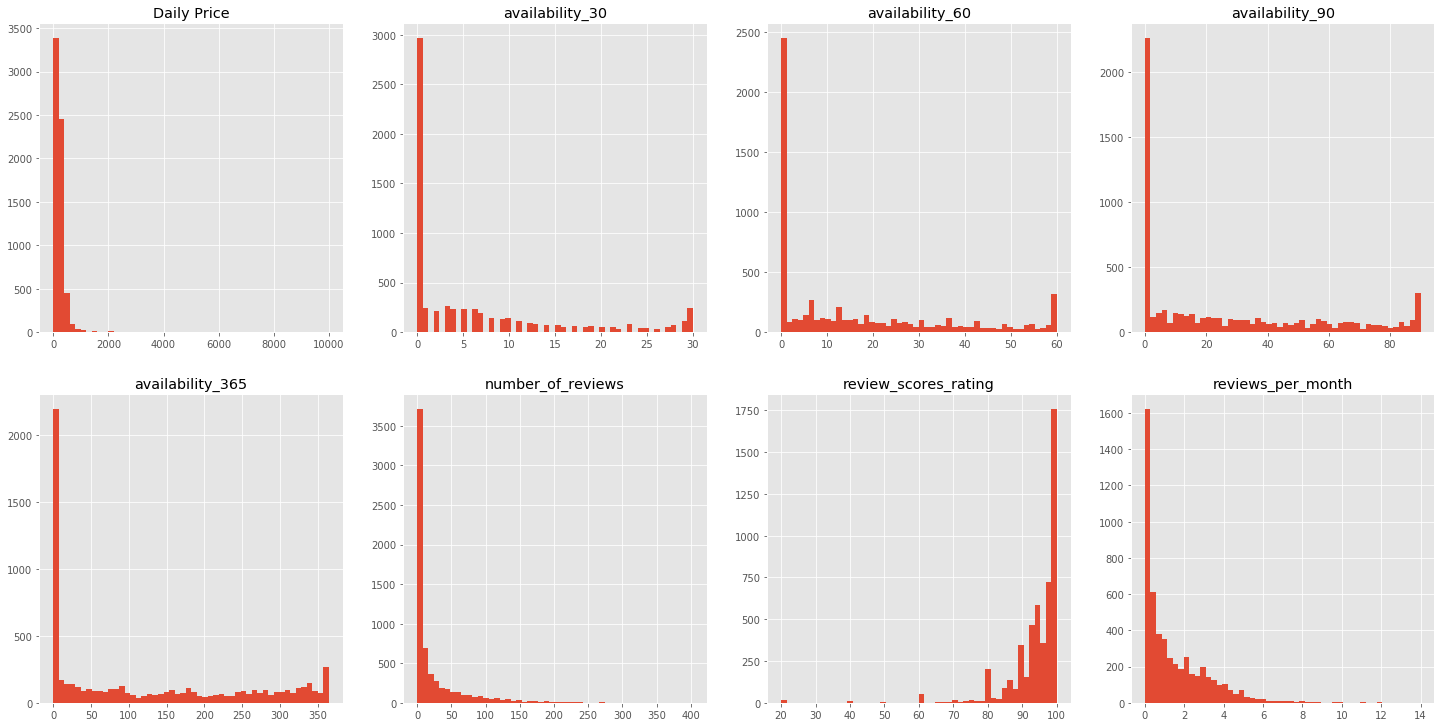

In [432]:
fig1 = plt.figure(figsize=(25,12.5))

ax1 = fig1.add_subplot(241)
ax1.hist(rent['price'], bins = 50)

ax2 = fig1.add_subplot(242)
ax2.hist(rent['availability_30'], bins = 50)

ax3 = fig1.add_subplot(243)
ax3.hist(rent['availability_60'], bins = 50)

ax4 = fig1.add_subplot(244)
ax4.hist(rent['availability_90'], bins = 50)

ax5 = fig1.add_subplot(245)
ax5.hist(rent['availability_365'], bins = 50)

ax6 = fig1.add_subplot(246)
ax6.hist(rent['number_of_reviews'], bins = 50)

ax7 = fig1.add_subplot(247)
ax7.hist(rent['review_scores_rating'], bins = 50)

ax8 = fig1.add_subplot(248)
ax8.hist(rent['reviews_per_month'], bins = 50)

ax1.set_title('Daily Price')
ax2.set_title('availability_30')
ax3.set_title('availability_60')
ax4.set_title('availability_90')
ax5.set_title('availability_365')
ax6.set_title('number_of_reviews')
ax7.set_title('review_scores_rating')
ax8.set_title('reviews_per_month')

plt.show()

The distributions for each column show that there is no evident anomalies in each column data. To further test this notation, we draw a boxplot for each region to double check whether there is any outliers.

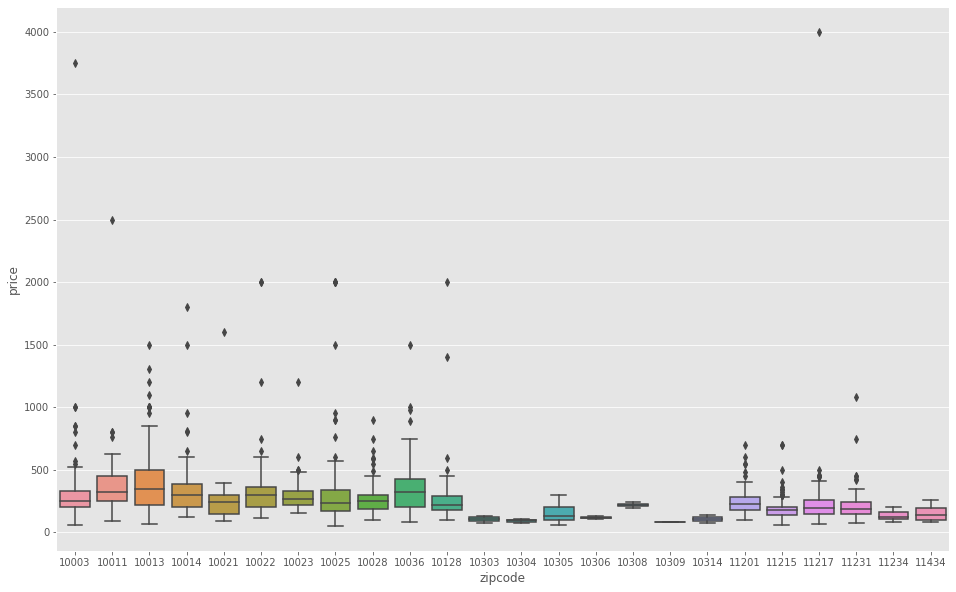

In [433]:
plt.figure(figsize = (16,10))
sns.boxplot(x="zipcode",y="price",data=daily)
plt.show()

In [434]:
daily[daily['zipcode'] == 10003].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
157,10003,3750.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000
588,10003,1000.0,20,50,80,349,19,100.0,0.51,0.666667,0.833333,0.888889,0.956164
586,10003,999.0,23,44,74,164,11,100.0,0.28,0.766667,0.733333,0.822222,0.449315
731,10003,850.0,30,60,90,180,0,NaN,NaN,1.000000,1.000000,1.000000,0.493151
148,10003,850.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [435]:
daily[daily['zipcode'] == 10011].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
156,10011,2500.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000
406,10011,800.0,0,0,23,266,22,99.0,0.48,0.000000,0.000000,0.255556,0.728767
974,10011,800.0,0,0,0,0,11,100.0,0.56,0.000000,0.000000,0.000000,0.000000
34,10011,760.0,28,56,86,361,7,100.0,0.08,0.933333,0.933333,0.955556,0.989041
988,10011,625.0,0,0,0,0,10,100.0,0.59,0.000000,0.000000,0.000000,0.000000


In [436]:
daily[daily['zipcode'] == 10021].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
158,10021,1600.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1134,10021,395.0,11,41,71,346,0,NaN,NaN,0.366667,0.683333,0.788889,0.947945
1213,10021,380.0,16,41,71,156,4,95.0,0.51,0.533333,0.683333,0.788889,0.427397
1255,10021,350.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1473,10021,320.0,4,20,28,57,1,100.0,1.00,0.133333,0.333333,0.311111,0.156164


In [437]:
daily[daily['zipcode'] == 10025].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
25,10025,2000.0,0,0,0,0,30,99.0,0.33,0.000000,0.000000,0.000000,0.00000
294,10025,2000.0,29,59,89,364,9,98.0,0.17,0.966667,0.983333,0.988889,0.99726
74,10025,2000.0,29,59,89,364,59,97.0,0.71,0.966667,0.983333,0.988889,0.99726
293,10025,2000.0,29,59,89,364,9,98.0,0.18,0.966667,0.983333,0.988889,0.99726
153,10025,1500.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.00000


In [438]:
daily[daily['zipcode'] == 10128].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
1544,10128,1999.0,30,60,90,270,0,NaN,NaN,1.0,1.000000,1.000000,0.739726
1328,10128,1400.0,15,42,72,341,0,NaN,NaN,0.5,0.700000,0.800000,0.934247
380,10128,595.0,21,43,61,332,30,97.0,0.63,0.7,0.716667,0.677778,0.909589
76,10128,500.0,0,28,58,148,60,94.0,0.93,0.0,0.466667,0.644444,0.405479
1220,10128,450.0,24,54,84,345,5,92.0,0.71,0.8,0.900000,0.933333,0.945205


In [439]:
daily[daily['zipcode'] == 11217].sort_values(by = 'price', ascending = False).head(5)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
88,11217,4000.0,24,54,83,83,0,NaN,NaN,0.800000,0.900000,0.922222,0.227397
725,11217,500.0,0,21,50,50,0,NaN,NaN,0.000000,0.350000,0.555556,0.136986
1101,11217,460.0,0,5,16,114,2,100.0,0.24,0.000000,0.083333,0.177778,0.312329
1054,11217,450.0,8,22,22,22,3,100.0,0.35,0.266667,0.366667,0.244444,0.060274
492,11217,450.0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000


Based on the boxplot, we test certain regions with  evident outliers. We pick out the outliers and manually check if it is a bad data. The result above shows that the highest price data record in '10003', '10011' and '10021' are likely to be bad data, since none of the columns accept 'price' has any value. So we need to remove those data records before analysis.

In [440]:
daily = daily.drop([daily.index[156], daily.index[157], daily.index[158]])

In [441]:
daily.reset_index(drop=True)

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
0,11215,225.0,0,0,0,0,4,100.0,0.16,0.000000,0.000000,0.000000,0.000000
1,11217,250.0,0,0,0,158,21,99.0,0.30,0.000000,0.000000,0.000000,0.432877
2,11231,175.0,21,39,69,342,233,93.0,2.09,0.700000,0.650000,0.766667,0.936986
3,10023,235.0,0,16,16,199,27,92.0,0.27,0.000000,0.266667,0.177778,0.545205
4,11215,400.0,0,17,17,216,16,95.0,0.24,0.000000,0.283333,0.188889,0.591781
5,11201,140.0,0,0,0,0,4,90.0,0.04,0.000000,0.000000,0.000000,0.000000
6,11215,250.0,0,0,0,0,80,94.0,2.17,0.000000,0.000000,0.000000,0.000000
7,11231,165.0,12,37,67,342,150,92.0,1.40,0.400000,0.616667,0.744444,0.936986
8,11215,270.0,0,0,6,272,21,97.0,0.26,0.000000,0.000000,0.066667,0.745205
9,10013,135.0,0,0,0,0,21,92.0,0.20,0.000000,0.000000,0.000000,0.000000


In [442]:
daily_renting_price = daily.groupby('zipcode')\
                            .agg({'price':'mean','number_of_reviews':'size','availability_30_ratio':'mean','availability_60_ratio':'mean', 'availability_90_ratio':'mean', 'availability_365_ratio':'mean'})\
                            .rename(columns={'price':'mean_price','number_of_reviews':'count', 'availability_30_ratio':'a30', 'availability_60_ratio':'a60', 'availability_90_ratio':'a90', 'availability_365_ratio':'a365'})\
                            .reset_index()

In [443]:
daily_renting_price.head()

,zipcode,mean_price,count,a30,a60,a90,a365
0,10003,300.770370,135,0.189383,0.252716,0.267654,0.298102
1,10011,353.514286,105,0.175873,0.243016,0.267407,0.288898
2,10013,412.466667,105,0.327937,0.368095,0.365608,0.330124
3,10014,348.955556,90,0.221111,0.272407,0.281358,0.257108
4,10021,230.923077,26,0.170513,0.211538,0.226923,0.302213


## Exploratory Data Analysis

### Zillow Real Estate Price

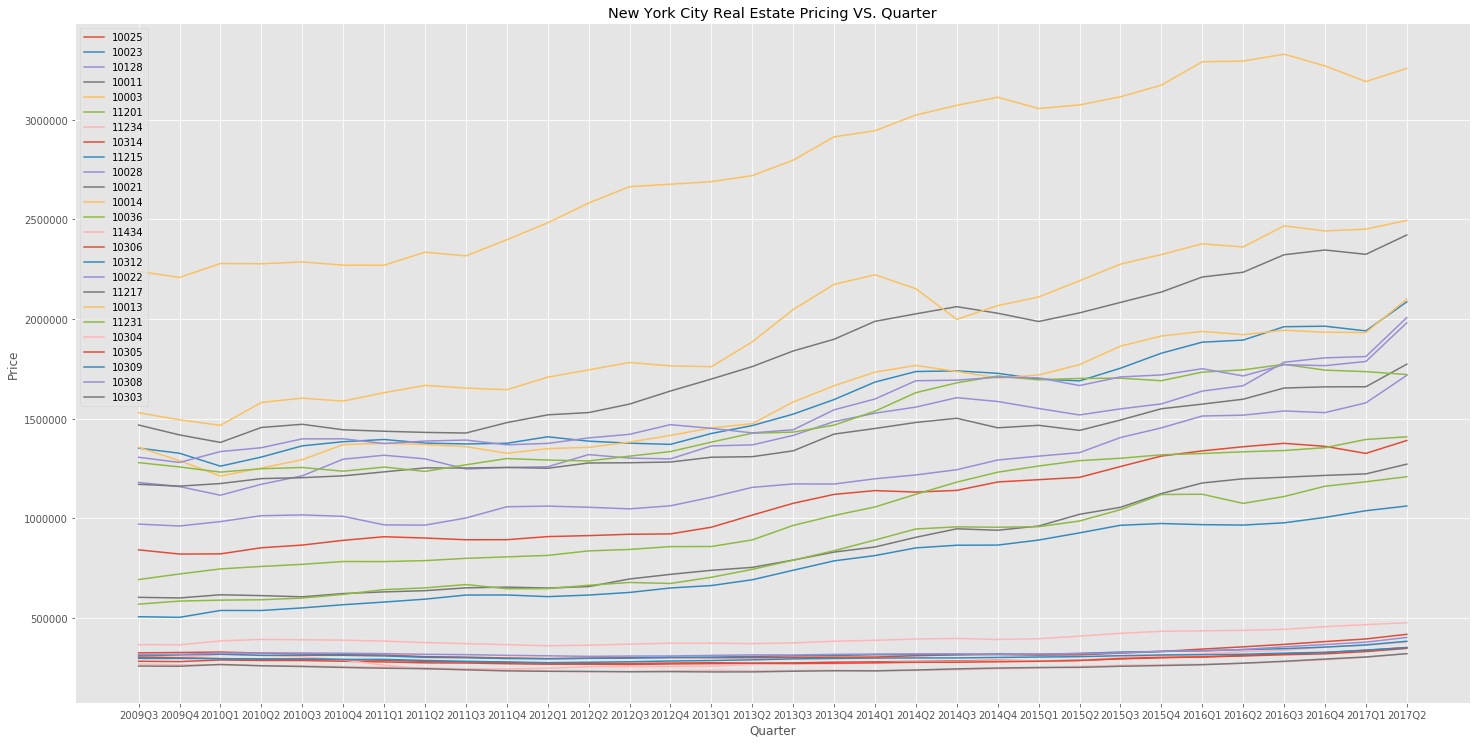

In [444]:
# Real Estate Pricing by Quarter (recent 10 years)
plt.style.use('ggplot')
plt.figure(figsize=(25,12.5))
labels = quarter_price.columns.values
x = quarter_price.index.values
y = []

for col in quarter_price.columns.values:
    y.append(quarter_price[col].values.tolist())

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label = label)

plt.legend()
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.title('New York City Real Estate Pricing VS. Quarter')
plt.show()

In [445]:
# To locate regions that have a steady real estate price over time
check2[check2['2017-06'] < 500000]

,RegionName,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
6,11234,369100.0,367300.0,365400.0,364000.0,364300.0,369700.0,378700.0,386600.0,391600.0,...,448400,452300,457200,461200.0,464400,466400,470900,475700,477100,476900
7,10314,285400.0,283400.0,281500.0,280500.0,280500.0,284000.0,288700.0,290800.0,290200.0,...,322600,325000,326900,328800.0,332600,338600,344100,347800,352300,357300
13,11434,313900.0,310500.0,308600.0,306000.0,299400.0,303200.0,315400.0,320300.0,315800.0,...,342100,348300,356100,358400.0,357500,361900,370800,377100,380200,382300
14,10306,304300.0,303200.0,302500.0,302200.0,300900.0,298600.0,297200.0,296500.0,296100.0,...,316100,318300,321200,322900.0,325400,331700,339000,343500,347800,352900
15,10312,297900.0,297800.0,297500.0,298200.0,298200.0,297000.0,296200.0,296400.0,296900.0,...,325400,326600,328400,330300.0,333600,339300,345000,348400,351700,355000
20,10304,272200.0,269500.0,267300.0,266600.0,265500.0,265200.0,266200.0,266100.0,264700.0,...,284500,287100,290700,294700.0,299000,303800,308300,313800,321300,328300
21,10305,327100.0,324900.0,325200.0,326300.0,327000.0,328900.0,331100.0,330000.0,328100.0,...,373500,378600,382700,385300.0,387900,394500,403800,412000,418900,425100
22,10309,310800.0,310300.0,311800.0,313900.0,315000.0,317000.0,320000.0,320000.0,317400.0,...,348300,351100,354600,357900.0,360500,364900,371100,377200,383700,390500
23,10308,316600.0,316300.0,317100.0,318200.0,317400.0,319500.0,323400.0,324900.0,325000.0,...,360700,364300,367700,370100.0,372200,378000,387800,396400,402900,409500
24,10303,260800.0,259100.0,258500.0,258100.0,257000.0,260300.0,267300.0,269300.0,265700.0,...,287100,291500,294800,297200.0,300600,304700,309500,315400,322100,327700


In [446]:
# To find the top three regions based on the real estate price
check2.sort_values(by = ['2017-06'], ascending=False).head(3)

,RegionName,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
18,10013,2243500.0,2241000.0,2233600.0,2219900.0,2198000.0,2209300.0,2268700.0,2294100.0,2273600.0,...,3347100,3305500,3261100,3244000.0,3231400,3183300,3160200,3193500,3262200,3316500
11,10014,1551900.0,1532400.0,1507000.0,1496600.0,1502400.0,1485700.0,1451800.0,1454400.0,1494500.0,...,2480800,2443200,2430100,2452900.0,2451200,2441900,2460900,2494900,2498400,2491600
3,10011,1489200.0,1467000.0,1449400.0,1432100.0,1422700.0,1402200.0,1378600.0,1372300.0,1393100.0,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400


The graphs of real estate pricing over the past ten years discloses that **'11234', '10314', '11434', '10306', '10312', '10304', '10305', '10309', '10308' and '10303'** are the regions that barely have any increase in the real estate price. The rest of the regions are all increasing steadily during these years. The top three price region are **'10013', '10014' and '10011'**.

### Airbnb Rental Price and Quantity

In order to collect some initial findings for Airbnb business insight, we can write a bar plot function to generate different graphs for observing the relations between zipcode and average price or the relations between zipcode and number of properties for each region.

In [447]:
# Plotting Function 1: Bar plot
def price_quantity_graph(df, col, color, ylabel_name, title_name):
    plt.figure(figsize=(16, 8))
    y_pos = np.arange(len(df['zipcode']))

    plt.bar(y_pos, df[col], color = color)
    plt.xlabel('Zipcode')
    plt.ylabel(ylabel_name)
    plt.title(title_name)
    plt.xticks(y_pos, df['zipcode'])
    plt.show()

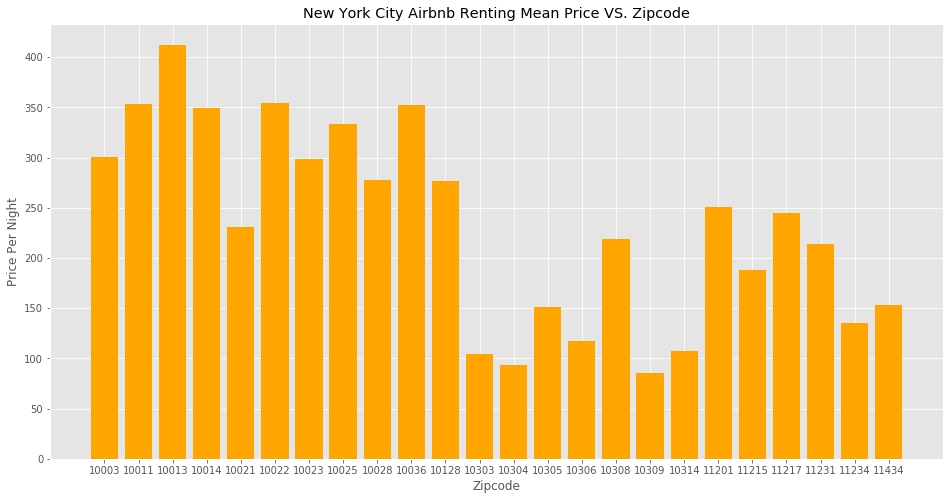

In [448]:
price_quantity_graph(daily_renting_price, \
                     'mean_price', \
                     'orange','Price Per Night', \
                     'New York City Airbnb Renting Mean Price VS. Zipcode')

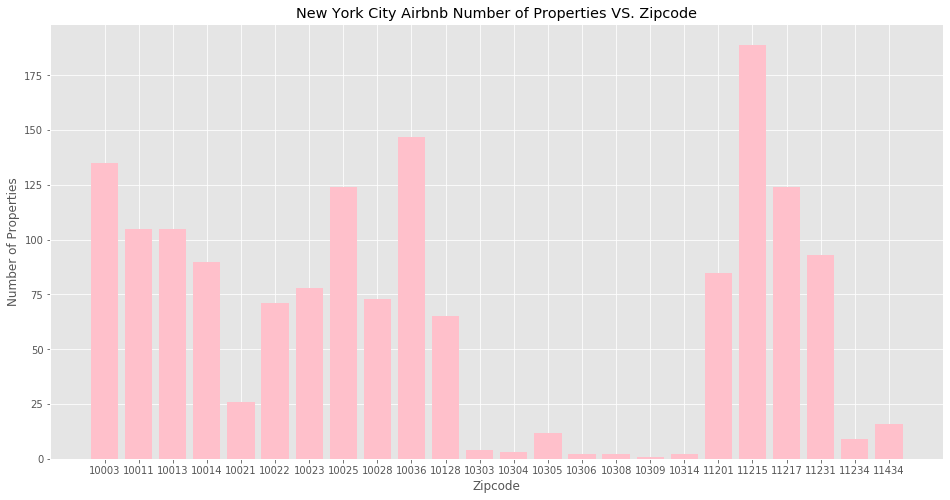

In [449]:
price_quantity_graph(daily_renting_price, \
                     'count', \
                     'pink','Number of Properties', \
                     'New York City Airbnb Number of Properties VS. Zipcode')

The reantal price of Airbnb for different region is basically consistent with Zillow real estate data, especially for the top three "Zillow" region - **'10013', '10014' and '10011'**. We also noticed that among the top seven "Airbnb" region, **'10025' and '10036'** is not ranking that high in the Zillow region data. This catch our attention since it might be a good place to invest since the rental price is high while the cost of real estate is not that high. This is a basic assumption and needed to be delicatedly calculate for justification.

### Airbnb Property Availability

Before we get down to the revenue level analysis, it is also very helpful for us to understand the popularity, which is reflected by the availability data. The availability is not directly lead to the final result, but is the intermediate process to calculate the revenue statistics. In a way, the availability is a good point to understand whether a region is popular or not. If it is popular, it might generate a impact on the investment value sooner or later. 

Beside the distribution of important features across different rergions, we also interested in some inner correlation between some key attributions. To visualize the relation between them, we can draw scatter plots. Here we write a function to plot the graphs about availability condition. 

In [450]:
# Write a function to plot scatter plot for the relation between price and avaliability
cmap = sns.diverging_palette(220, 10, as_cmap=True)
def inner_correlation_graph(df, x_col, y_col, xlabel_name, ylabel_name, title_name):
    x = df[x_col]
    y = df[y_col]

    n = df['zipcode']

    fig, ax = plt.subplots(figsize=(25, 12.5))
    ax.scatter(x, y, c=y,cmap = cmap , s =500)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i],y[i]), fontsize = 10)

    plt.xlabel(xlabel_name, fontsize=20)    
    plt.ylabel(ylabel_name, fontsize=20)
    plt.title(title_name, fontsize=20, fontweight='bold')
    plt.show()

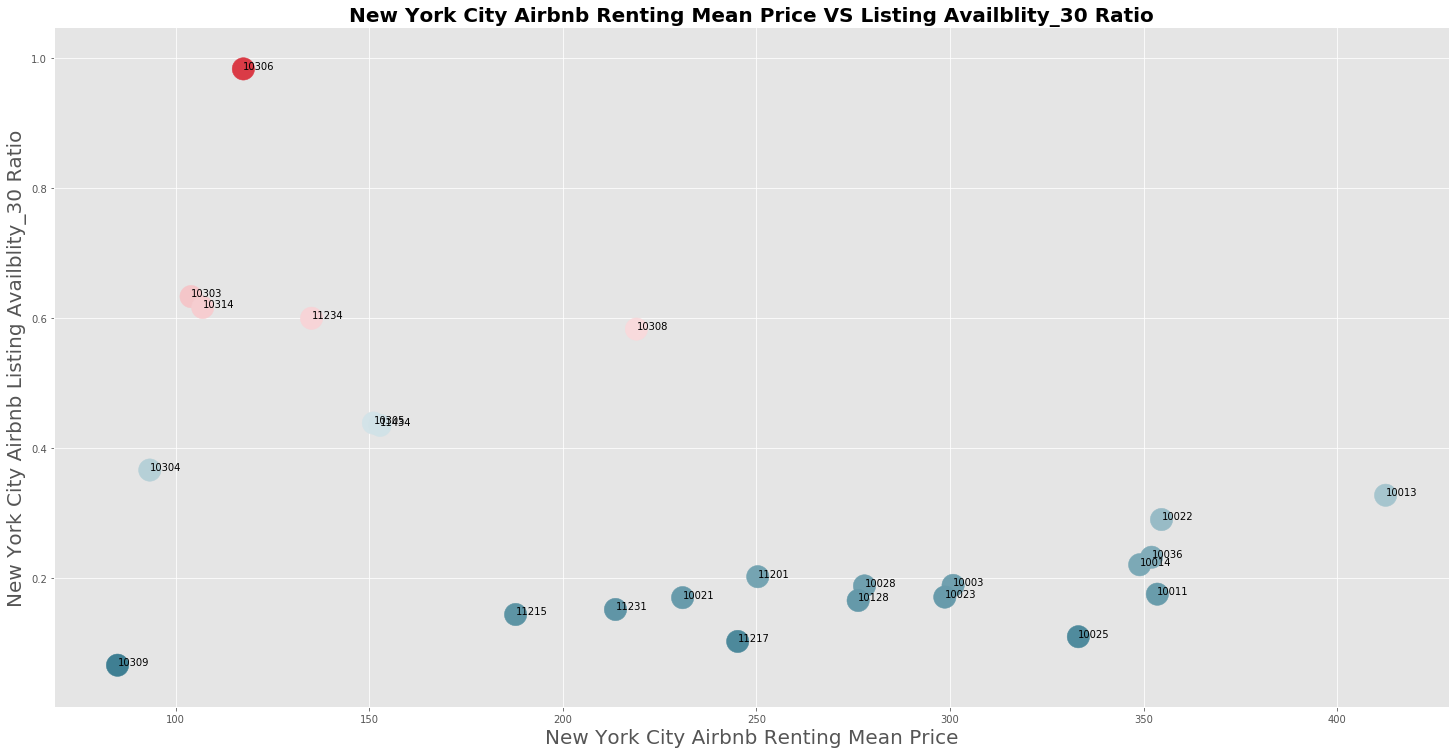

In [451]:
inner_correlation_graph(daily_renting_price, \
                        'mean_price', \
                        'a30', \
                        'New York City Airbnb Renting Mean Price', \
                        'New York City Airbnb Listing Availblity_30 Ratio', \
                        'New York City Airbnb Renting Mean Price VS Listing Availblity_30 Ratio')

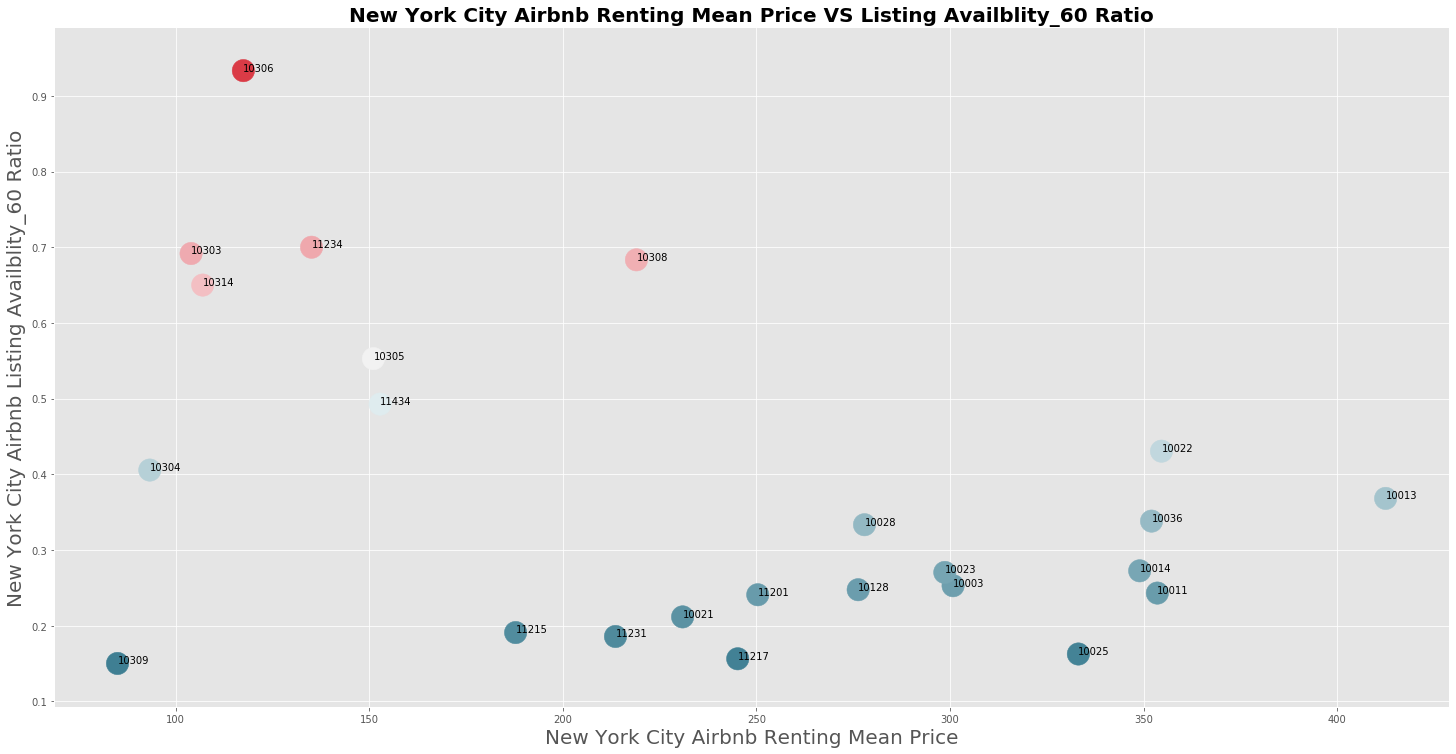

In [452]:
inner_correlation_graph(daily_renting_price, \
                        'mean_price', \
                        'a60', \
                        'New York City Airbnb Renting Mean Price', \
                        'New York City Airbnb Listing Availblity_60 Ratio', \
                        'New York City Airbnb Renting Mean Price VS Listing Availblity_60 Ratio')

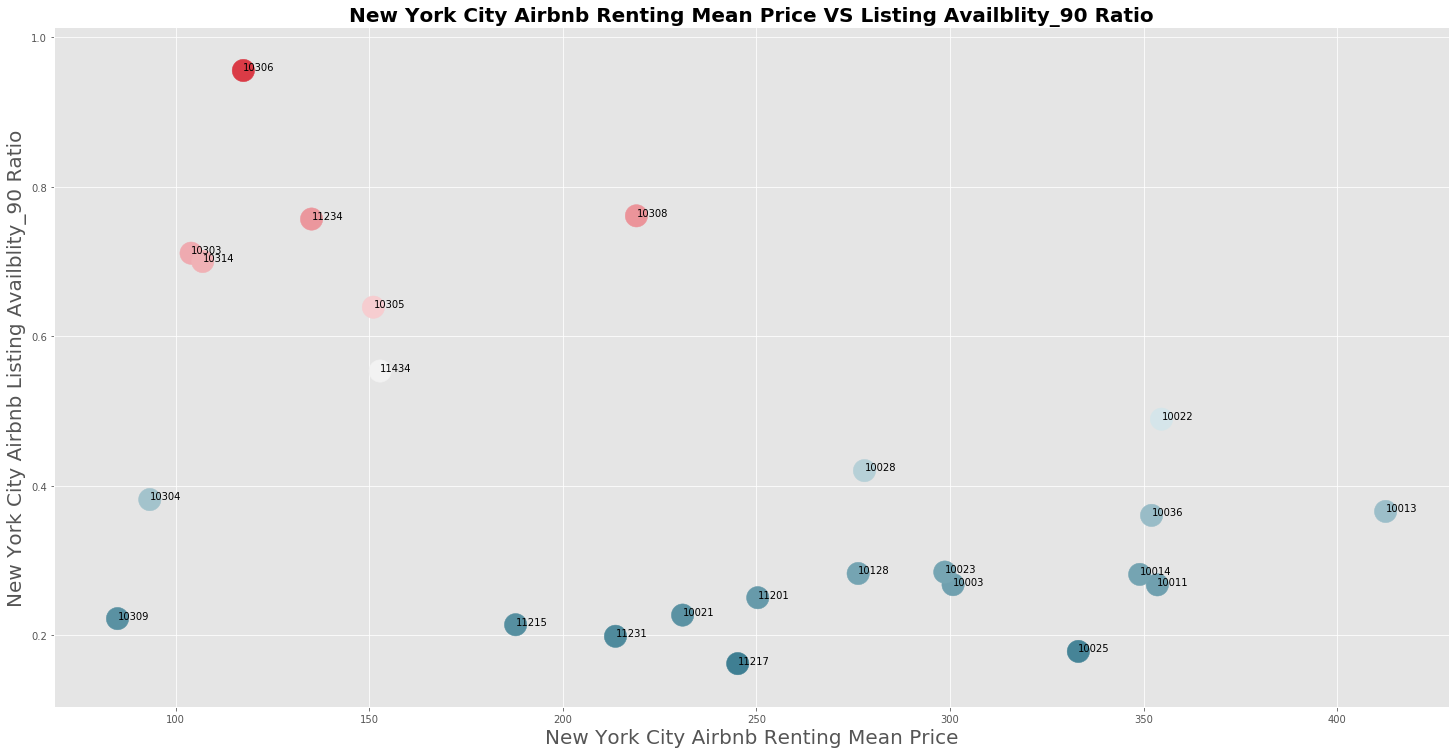

In [453]:
inner_correlation_graph(daily_renting_price, \
                        'mean_price', \
                        'a90', \
                        'New York City Airbnb Renting Mean Price', \
                        'New York City Airbnb Listing Availblity_90 Ratio', \
                        'New York City Airbnb Renting Mean Price VS Listing Availblity_90 Ratio')

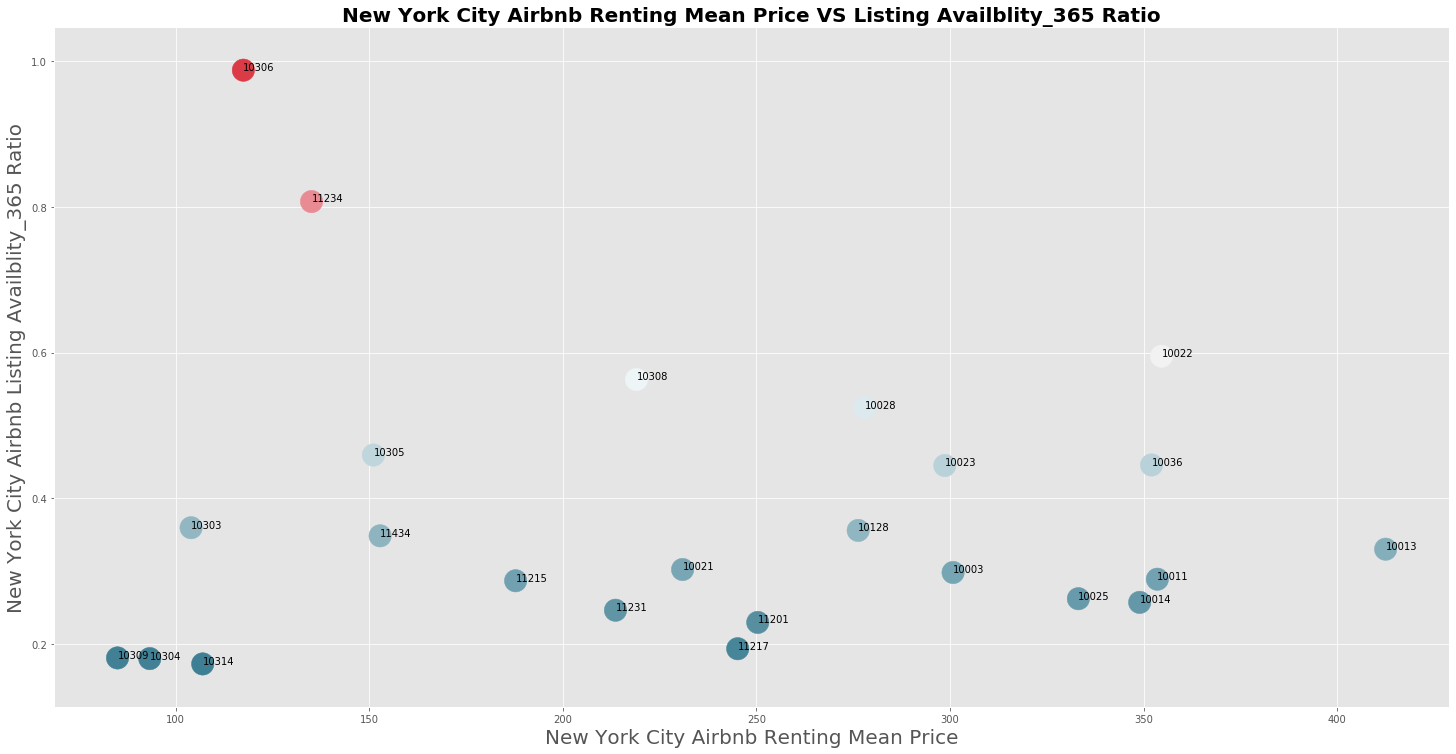

In [454]:
inner_correlation_graph(daily_renting_price, \
                        'mean_price', \
                        'a365', \
                        'New York City Airbnb Renting Mean Price', \
                        'New York City Airbnb Listing Availblity_365 Ratio', \
                        'New York City Airbnb Renting Mean Price VS Listing Availblity_365 Ratio')

### Key Findings

1. The '10013', '10014' and '10011' regions have the highest value in terms of real estate price in the past ten years. They also show a high possiblity of continue going upward for the following years.  

2. In terms of whole year availability, we find more than 60% regions have a low availability(less than 40%) - means high occupancy and popularity - among all the regions in New York City. This gives us a basic sense of what are the most popular region(10309, 10304, 10314). And chance is that those region will also accrod with final result to some extent.

3. And for those 60% regions with high occupancy, their rental price is relatively evenly distributed across the price range. This tells us that there is no evident relations between people's perference on price in terms of region popularity. Therefore, we can possibly say that their perference for a region is purly out of this region, rather than price consideration.

## Tactics

### Zillow Price Multiplier Model

The data in Airbnb dataset is scratched from 07/2019. However, the Zillow dataset is only up to 07/2017. In order to make Zillow data to be in the same time with Airbnb data, we can make a rough mutiplier model to use historical data to predict 07/2019's real estate price data. The polyfit function is eligible to fit a linear trend line for the real estate price data. We store the coeffcient and intercept of the linear predicting model for each region in a dataframe. Based on the statistics we derived from the models, we are able to calculate the approximate price data for different region in 07/2019.

In [455]:
# Fit the Real Estate price with trend line and store the slope for each one
from numpy.polynomial import polynomial as P
dp = {}
its = {}
for col in quarter_price.columns.tolist():
    x = np.linspace(0,31,32)
    y = quarter_price[col]
    c, stats = P.polyfit(x,y,1,full=True)
    dp[col] = c[1]
    its[col] = c[0]


trend_lines = pd.DataFrame({'dp':pd.Series(dp),'its':pd.Series(its)})
trend_lines['2019-07'] = 56 * trend_lines['dp'] + trend_lines['its']

trend_lines.head()

,dp,its,2019-07
10025,20282.209189,7.559008e+05,1.891704e+06
10023,24452.339932,1.204559e+06,2.573890e+06
10128,22414.064027,8.603487e+05,2.115536e+06
10011,35404.111681,1.266579e+06,3.249209e+06
10003,26951.496823,1.172307e+06,2.681591e+06


#### Development Potential Factor

The coefficient for different region model reflects the different degree of markups, which gives us a glimpse on each region's development potential. Th higher coefficint it is, the more sustainable development value it has. Therefore, we can use these coefficents as "Development Potential Factor".

However, the original coefficient is not very straightforward. In order to make them scalable, we can apply normalization on them. Here we treat largest coefficient as "1".

In [456]:
# Normalization: The biggest
trend_lines['dp_normalized'] = trend_lines['dp'] / max(trend_lines['dp'])

In [457]:
trend_lines.head()

,dp,its,2019-07,dp_normalized
10025,20282.209189,7.559008e+05,1.891704e+06,0.494029
10023,24452.339932,1.204559e+06,2.573890e+06,0.595604
10128,22414.064027,8.603487e+05,2.115536e+06,0.545957
10011,35404.111681,1.266579e+06,3.249209e+06,0.862365
10003,26951.496823,1.172307e+06,2.681591e+06,0.656478


#### Airbnb Rental Price vs Zillow Cost Data

Now we have both current Zillow real estate data and Airbnb data, we can try to understand what is the relationship between property price and rental price. Ideally, property price and rental price should have a rough linear relation. It is not hard to imagine that the property price is used as rerference when pricing the airbnb listing. In the following step, we are going to use scatter plot to test whether those two variables have some inner relation.

In [458]:
airbnb_zillow= daily_renting_price.merge(trend_lines, how = 'inner',left_on = 'zipcode', right_index = True)

In [459]:
airbnb_zillow.head()

,zipcode,mean_price,count,a30,a60,a90,a365,dp,its,2019-07,dp_normalized
0,10003,300.770370,135,0.189383,0.252716,0.267654,0.298102,26951.496823,1.172307e+06,2.681591e+06,0.656478
1,10011,353.514286,105,0.175873,0.243016,0.267407,0.288898,35404.111681,1.266579e+06,3.249209e+06,0.862365
2,10013,412.466667,105,0.327937,0.368095,0.365608,0.330124,41054.661535,2.132918e+06,4.431979e+06,1.000000
3,10014,348.955556,90,0.221111,0.272407,0.281358,0.257108,34872.543988,1.418028e+06,3.370890e+06,0.849417
4,10021,230.923077,26,0.170513,0.211538,0.226923,0.302213,17736.180352,1.111195e+06,2.104422e+06,0.432014


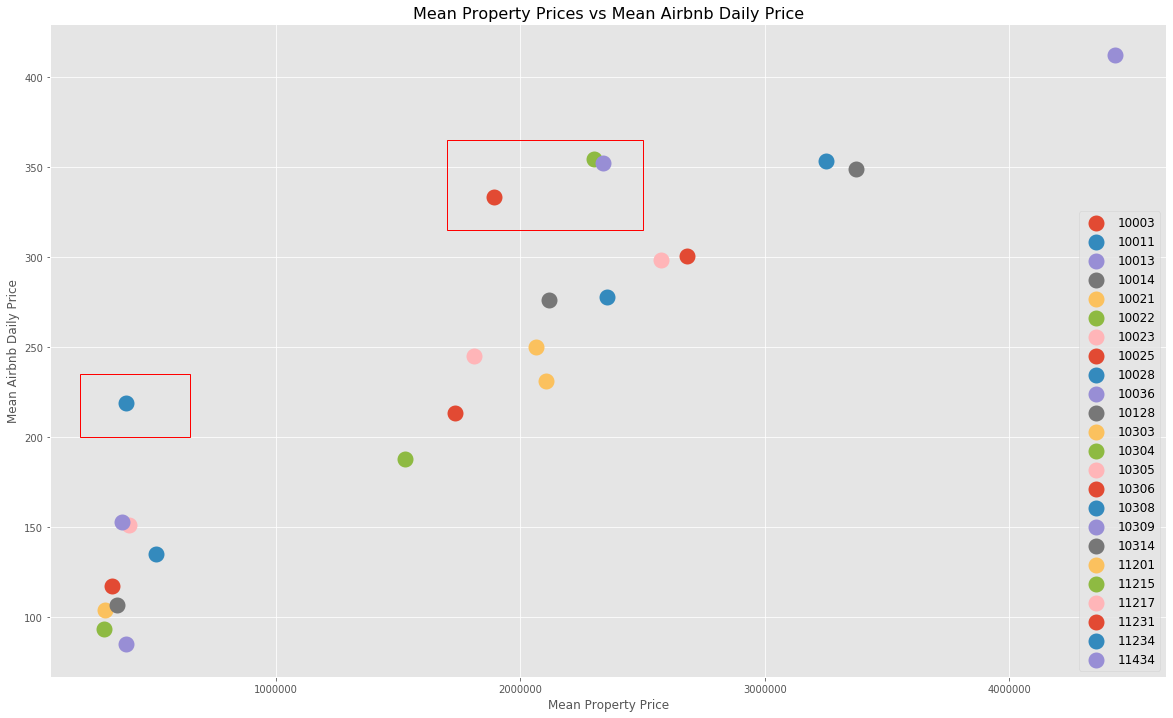

In [460]:
fig1= plt.figure(figsize=(20,12))
ax1 = fig1.add_subplot(111)
for zipcode in airbnb_zillow['zipcode']:
    ax1.scatter(airbnb_zillow[airbnb_zillow['zipcode'] == zipcode]['2019-07'], airbnb_zillow[airbnb_zillow['zipcode'] == zipcode]['mean_price'],label = zipcode, linewidth = 10, cmap = 'tab20')

rect1 = patches.Rectangle((200000,200),450000,35,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((1700000,315),800000,50,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect1)
ax1.add_patch(rect2)
ax1.set_xlabel("Mean Property Price")
ax1.set_ylabel("Mean Airbnb Daily Price")
ax1.set_title("Mean Property Prices vs Mean Airbnb Daily Price", fontsize = 16)
ax1.legend(prop={'size':12})
plt.show()

According to the graph above, we can see a clear linear correlation between Zillow property price with Airbnb rental price. Most of the data points are around a straight line. However, we also notice some data points that are relatively far from the trend line. Those data points imply that the airbnb price for this region in better than the cost price. This might be a signal that **'10308', '10025', '10022'and '10036'** are of great investment value.

### Property Occupancy

One key factor in profit model is the occupancy of each property, instead of just simply assuming the occupancy is 75%, we can refine this arithmetic using the availability information in the dataset. There are four columns that contains the availability - 30 days, 60 days, 90 days and 365 days. The first three are possibly biasd data considering the seasonality across different quaters. Therefore, we choose to use availability of 365 days to roughly estimate the occupancy for different region.

In [461]:
daily.head()

,zipcode,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,availability_30_ratio,availability_60_ratio,availability_90_ratio,availability_365_ratio
0,11215,225.0,0,0,0,0,4,100.0,0.16,0.0,0.000000,0.000000,0.000000
1,11217,250.0,0,0,0,158,21,99.0,0.30,0.0,0.000000,0.000000,0.432877
2,11231,175.0,21,39,69,342,233,93.0,2.09,0.7,0.650000,0.766667,0.936986
3,10023,235.0,0,16,16,199,27,92.0,0.27,0.0,0.266667,0.177778,0.545205
4,11215,400.0,0,17,17,216,16,95.0,0.24,0.0,0.283333,0.188889,0.591781


In [462]:
occp = daily
occp['occupancy_365_ratio'] = 1 - occp['availability_365_ratio']
occp['next_year_revenue'] = occp['price'] * 365 * occp['occupancy_365_ratio']
revenue = occp.groupby('zipcode')\
            .agg({'next_year_revenue':'sum','number_of_reviews':'size'})\
            .rename(columns={'next_year_revenue':'total revenue','number_of_reviews':'property number'})\
            .reset_index()
revenue.set_index(['zipcode'], inplace = True, drop = True)

In [463]:
revenue.head()

,total revenue,property number
zipcode,,
10003,10037317.0,135
10011,8966477.0,105
10013,9466314.0,105
10014,7635449.0,90
10021,1512441.0,26


In [464]:
data = revenue.merge(trend_lines, left_index=True, right_index=True)

In [465]:
data.head()

,total revenue,property number,dp,its,2019-07,dp_normalized
10003,10037317.0,135,26951.496823,1.172307e+06,2.681591e+06,0.656478
10011,8966477.0,105,35404.111681,1.266579e+06,3.249209e+06,0.862365
10013,9466314.0,105,41054.661535,2.132918e+06,4.431979e+06,1.000000
10014,7635449.0,90,34872.543988,1.418028e+06,3.370890e+06,0.849417
10021,1512441.0,26,17736.180352,1.111195e+06,2.104422e+06,0.432014


### Capitalization Rate and Region Value Metric

In [466]:
data['cap rate'] = data['total revenue'] / (data['2019-07'] * data['property number'])
data['region value metric'] = data['cap rate'] * data['dp_normalized']

In [467]:
data.head()

,total revenue,property number,dp,its,2019-07,dp_normalized,cap rate,region value metric
10003,10037317.0,135,26951.496823,1.172307e+06,2.681591e+06,0.656478,0.027726,0.018202
10011,8966477.0,105,35404.111681,1.266579e+06,3.249209e+06,0.862365,0.026282,0.022664
10013,9466314.0,105,41054.661535,2.132918e+06,4.431979e+06,1.000000,0.020342,0.020342
10014,7635449.0,90,34872.543988,1.418028e+06,3.370890e+06,0.849417,0.025168,0.021378
10021,1512441.0,26,17736.180352,1.111195e+06,2.104422e+06,0.432014,0.027642,0.011942


To better illustrate the capitalization rate, development potential and derived region value metrics, we create three bar plots in the following.

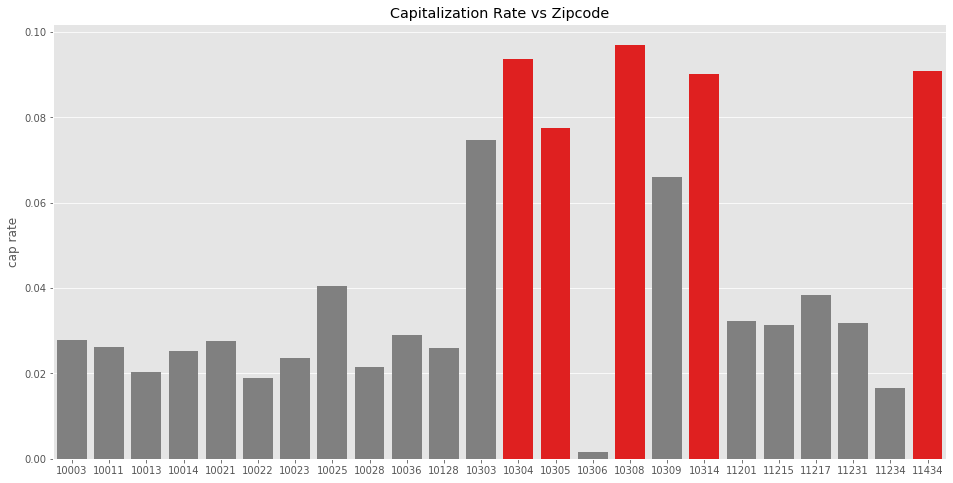

In [468]:
plt.figure(figsize=(16,8))
clrs = ['grey' if (x < sorted(data['cap rate'])[-5]) else 'red' for x in data['cap rate'] ]
sns.barplot(x = y_pos, y = data['cap rate'], palette=clrs)
plt.xticks(y_pos, data.index)
plt.title('Capitalization Rate vs Zipcode')
plt.show()

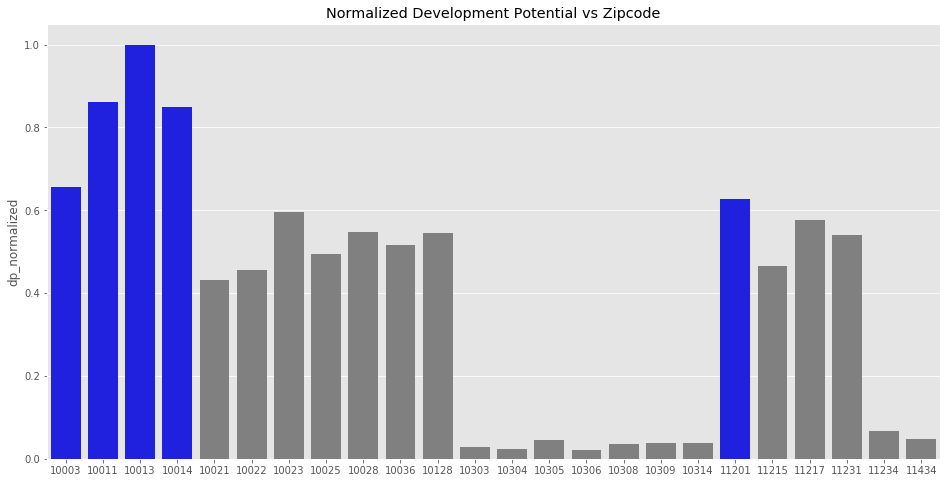

In [469]:
plt.figure(figsize=(16,8))
clrs = ['grey' if (x < sorted(data['dp_normalized'])[-5]) else 'blue' for x in data['dp_normalized'] ]
sns.barplot(x = y_pos, y = data['dp_normalized'], palette=clrs)
plt.xticks(y_pos, data.index)
plt.title('Normalized Development Potential vs Zipcode')
plt.show()

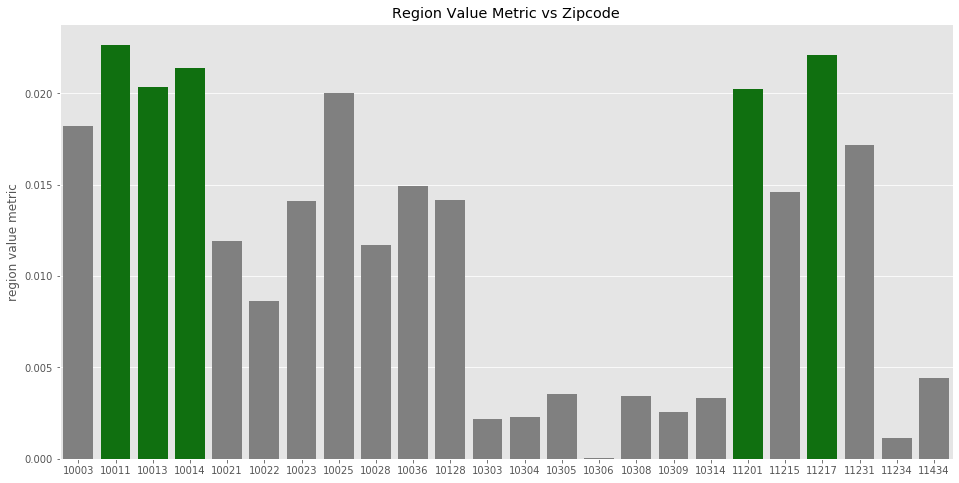

In [470]:
plt.figure(figsize=(16,8))
clrs = ['grey' if (x < sorted(data['region value metric'])[-5]) else 'green' for x in data['region value metric'] ]
sns.barplot(x = y_pos, y = data['region value metric'], palette=clrs)
plt.xticks(y_pos, data.index)
plt.title('Region Value Metric vs Zipcode')
plt.show()

According to the above graphs:
1. The Capitalization Rate shows that **'10304', '10305', '10308', '10314' and '11434'** are the top five valuable regions for short term rental invest.

2. The Development Potential shows that **'10003', '10011', '10013', '10014' and '11201'** have the highest potential to grow faster than other regions in terms of Real Estate value.

3. The Region Value Metrics shows that, when take both Capitalization Rate and Development Potential into consideraition, **'10011', '10013', '10014', '11201' and '11217'** are the top five promosing region for invest.

## Recommendation

Based on the Zillow and Airbnb dataset, we now have some important business insights towards Capitalization Rate, Development Potential and Region Value Metric. In order to expand short-term rental business, we first need to consider the initial Capitalization Rate and then Region Value Metric. In general, Capitalization Rate is the direct reflection of what are the most profitable region in relatively short term. The Region Value Metric, which also takes rergion's development potential is more for a longer aspects.  

To sum up, we have some recommendations as follow:  

1. We recommend our client to first invest on **'10304', '10305', '10308', '10314' and '11434'** for now. The capitalization rate guarantee that these rergions have the highest investment value for current stage.

2. We also rercommend our client to pay special attetion on **'10011', '10013', '10014', '11201' and '11217'** in the folllowing time. These regions might show a strong development potential in both the capitalization rate as well as the overall region development level.

## What's Next

As we dig more into this project, we find that there are several things can be further imporved. Some of them are about data, others are about methodnology.

**For data part:**  
It might be better if we have some data about region's attributions. For example, the public transit convenience level of a region or the safety level of a region. These "soft metric"s can be transformed and used in the final metric establishment. The more comprehensive the metric is, the more accurate the result is. 

**For methodnology part:**  
Curently, we use a simple mutiplier model to predict the Real Estate price in 07/2019. But if we can try to apply time-sries model to forecast the price data, it might increase the accuracy to some degree.